# Exploration and Comparison of Transformers for Image Classification

## Fine-tuning with data augmentations using Swin Transformer (Swin)

Fine-tuning is an experiment that involves training the entire model on new data. All of the model's parameters are end-to-end fine-tuned on the provided dataset.

Data augmentation is a series of techniques that generate artificial data by manipulating existing
data samples. By leveraging data augmentation techniques, AI models can achieve significantly improved
applicability in tasks involving scarce or imbalanced datasets, thereby substantially enhancing AI models’
generalization capabilities.

https://arxiv.org/abs/2405.09591

Apart from using data augmentations, this experiment also introduces new hyperparameters and regularization techniques to further improve the performance of the model.

### Swin Transformer (Swin)

Swin Transformer model trained on ImageNet-1k at resolution 224x224. It was introduced in the paper *Swin Transformer: Hierarchical Vision Transformer using Shifted Windows by Liu et al.*

https://arxiv.org/abs/2103.14030

### Prerequisites

Load necessary packages.

In [4]:
import os
import random

os.chdir('../../../')

import pandas as pd
import torch
from datasets import DatasetDict, concatenate_datasets, load_dataset
from src.dataset_builder import ImageDataset
from src.models import *
from src.train import *
from utils.config import *
from utils.data_utils import *
from utils.models_utils import *
from utils.train_utils import *
from utils.visualization_utils import *

Check if there is GPU available.

In [5]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe
VRAM: 79.25 GB


Set manual seed for reproducibility.

In [6]:
id = 10
random.seed(id)
torch.manual_seed(10)

Load Swin image processor used for image pre-processing.

In [8]:
processor = get_backbone_processor(model_names["Swin"])

Print the pre-processing operations done by the processor.

In [9]:
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

### Data Preprocessing

Load each dataset and its splits.

NOTE: For this experiment, a validation set is required. Since some of the datasets don't have one, it is necessary to create one from a part of the training set.

Processor is automatically applied to each image.

#### RESISC45

In [10]:
resisc45 = load_dataset("timm/resisc45")
clean_labels(resisc45, name="resisc45")
resisc45_train = ImageDataset(
    dataset=resisc45["train"],
    processor=processor,
)
resisc45_validation = ImageDataset(
    dataset=resisc45["validation"],
    processor=processor,
)
resisc45_test = ImageDataset(
    dataset=resisc45["test"],
    processor=processor,
)

In [11]:
resisc45

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 18900
    })
    validation: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 6300
    })
    test: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 6300
    })
})

#### Food-101

In [12]:
food101 = load_dataset("ethz/food101")
clean_labels(food101, name="food101")

In [13]:
_food101 = food101["train"].train_test_split(test_size=0.333, seed=id)
food101 = DatasetDict(
    {
        "train": _food101["train"],
        "validation": _food101["test"],
        "test": food101["validation"],
    }
)

In [14]:
food101_train = ImageDataset(
    dataset=food101["train"],
    processor=processor,
)
food101_validation = ImageDataset(
    dataset=food101["validation"],
    processor=processor,
)
food101_test = ImageDataset(
    dataset=food101["test"],
    processor=processor,
)

In [15]:
food101

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 50525
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25225
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

#### FER2013

In [16]:
fer2013 = load_dataset("AutumnQiu/fer2013")
clean_labels(fer2013, name="fer2013")
fer2013_train = ImageDataset(
    dataset=fer2013["train"],
    processor=processor,
)
fer2013_validation = ImageDataset(
    dataset=fer2013["valid"],
    processor=processor,
)
fer2013_test = ImageDataset(
    dataset=fer2013["test"],
    processor=processor,
)

In [17]:
fer2013

DatasetDict({
    train: Dataset({
        features: ['label', 'image'],
        num_rows: 28709
    })
    valid: Dataset({
        features: ['label', 'image'],
        num_rows: 3589
    })
    test: Dataset({
        features: ['label', 'image'],
        num_rows: 3589
    })
})

#### PCam

In [18]:
pcam = load_dataset("zacharielegault/PatchCamelyon")
clean_labels(pcam, name="pcam")
pcam_train = ImageDataset(
    dataset=pcam["train"],
    processor=processor,
)
pcam_validation = ImageDataset(
    dataset=pcam["validation"],
    processor=processor,
)
pcam_test = ImageDataset(
    dataset=pcam["test"],
    processor=processor,
)

In [19]:
pcam

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 262144
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 32768
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 32768
    })
})

#### SUN397

In [20]:
sun397 = load_dataset("dpdl-benchmark/sun397")
clean_labels(sun397, name="sun397")
sun397_train = ImageDataset(
    dataset=sun397["train"],
    processor=processor,
)
sun397_validation = ImageDataset(
    dataset=sun397["validation"],
    processor=processor,
)
sun397_test = ImageDataset(
    dataset=sun397["test"],
    processor=processor,
)

In [21]:
sun397

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 76127
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 21750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 10875
    })
})

#### DTD

In [22]:
dtd = load_dataset("tanganke/dtd")
clean_labels(dtd, name="dtd")

In [23]:
_dtd = dtd["train"].train_test_split(test_size=0.1, seed=id)
dtd = DatasetDict(
    {
        "train": _dtd["train"],
        "validation": _dtd["test"],
        "test": dtd["test"],
    }
)

In [24]:
dtd_train = ImageDataset(
    dataset=dtd["train"],
    processor=processor,
)
dtd_validation = ImageDataset(
    dataset=dtd["validation"],
    processor=processor,
)
dtd_test = ImageDataset(
    dataset=dtd["test"],
    processor=processor,
)

In [25]:
dtd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3384
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 376
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1880
    })
})

### Data Augmentation

Torchvision supports common computer vision transformations in the `torchvision.transforms` and `torchvision.transforms.v2` modules. Transforms can be used to transform or augment data for training or inference of different tasks (image classification, detection, segmentation, video classification).

https://pytorch.org/vision/stable/transforms.html

Load the object containing data augmentations and apply it to a portion (15 %) of the datasets.

In [26]:
augmentations = get_data_augmentations()
augmentations

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomInvert(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.8, 1.2))
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))
    ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.3, 0.3))
)

#### RESISC45

In [27]:
sample = resisc45["train"].train_test_split(train_size=0.15, seed=id)["train"]
resisc45_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [28]:
resisc45_train_sample.augment_dataset(augmentations=augmentations, batch_size=64)

Map: 100%|██████████| 2835/2835 [01:27<00:00, 32.38 examples/s]

Augmentation completed. Total number of new samples generated: 2835


In [29]:
resisc45_train_augmented = concatenate_datasets(
    [resisc45_train.dataset, resisc45_train_sample.dataset]
)

In [30]:
resisc45_train = ImageDataset(
    dataset=resisc45_train_augmented,
    processor=processor,
)

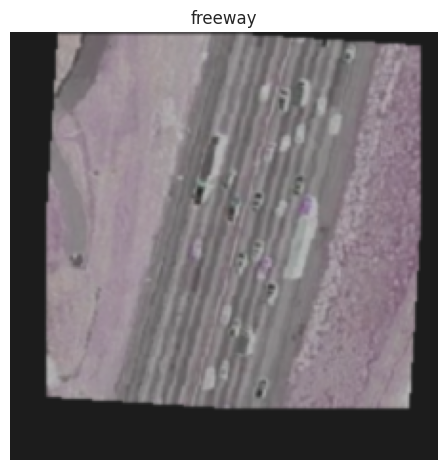

In [31]:
resisc45_train.plot_image(-1)

#### Food-101

In [32]:
sample = food101["train"].train_test_split(train_size=0.15, seed=id)["train"]
food101_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [33]:
food101_train_sample.augment_dataset(augmentations=augmentations, batch_size=64)

Map: 100%|██████████| 7578/7578 [03:55<00:00, 32.17 examples/s]

Augmentation completed. Total number of new samples generated: 7578


In [34]:
food101_train_augmented = concatenate_datasets(
    [food101_train.dataset, food101_train_sample.dataset]
)

In [35]:
food101_train = ImageDataset(
    dataset=food101_train_augmented,
    processor=processor,
)

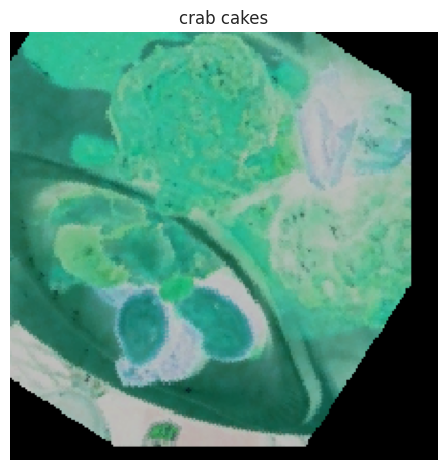

In [36]:
food101_train.plot_image(-1)

#### FER2013

In [37]:
sample = fer2013["train"].train_test_split(train_size=0.15, seed=id)["train"]
fer2013_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [38]:
fer2013_train_sample.augment_dataset(augmentations=augmentations, batch_size=64)

Map: 100%|██████████| 4306/4306 [01:08<00:00, 63.13 examples/s]

Augmentation completed. Total number of new samples generated: 4306


In [39]:
fer2013_train_augmented = concatenate_datasets(
    [fer2013_train.dataset, fer2013_train_sample.dataset]
)

In [40]:
fer2013_train = ImageDataset(
    dataset=fer2013_train_augmented,
    processor=processor,
)

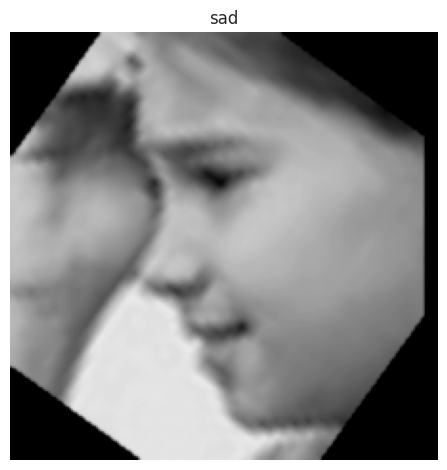

In [41]:
fer2013_train.plot_image(-1)

#### PCam

In [42]:
sample = pcam["train"].train_test_split(train_size=0.15, seed=id)["train"]
pcam_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [43]:
pcam_train_sample.augment_dataset(augmentations=augmentations, batch_size=64)

Map: 100%|██████████| 39321/39321 [17:47<00:00, 36.85 examples/s]

Augmentation completed. Total number of new samples generated: 39321


In [44]:
pcam_train_augmented = concatenate_datasets(
    [pcam_train.dataset, pcam_train_sample.dataset]
)

In [45]:
pcam_train = ImageDataset(
    dataset=pcam_train_augmented,
    processor=processor,
)

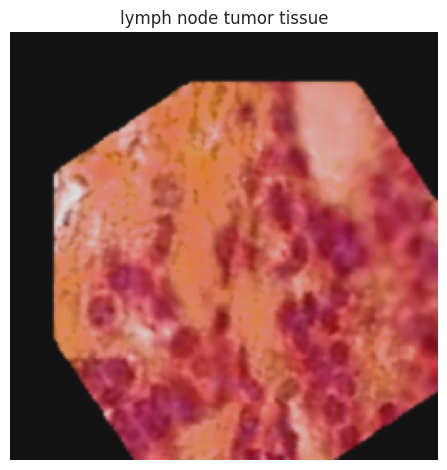

In [46]:
pcam_train.plot_image(-1)

#### SUN397

In [47]:
sample = sun397["train"].train_test_split(train_size=0.15, seed=id)["train"]
sun397_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [48]:
sun397_train_sample.augment_dataset(augmentations=augmentations, batch_size=64)

Map: 100%|██████████| 11419/11419 [05:48<00:00, 32.79 examples/s]

Augmentation completed. Total number of new samples generated: 11419


In [49]:
sun397_train_augmented = concatenate_datasets(
    [sun397_train.dataset, sun397_train_sample.dataset]
)

In [50]:
sun397_train = ImageDataset(
    dataset=sun397_train_augmented,
    processor=processor,
)

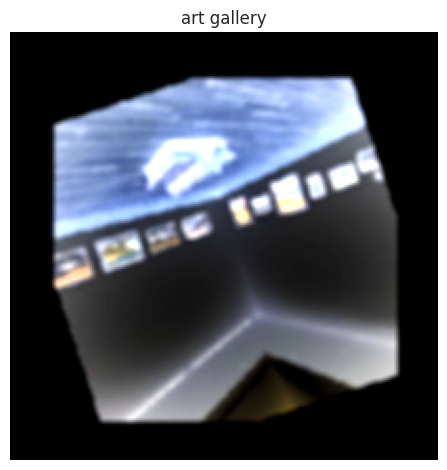

In [51]:
sun397_train.plot_image(-1)

#### DTD

In [52]:
sample = dtd["train"].train_test_split(train_size=0.15, seed=id)["train"]
dtd_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [53]:
dtd_train_sample.augment_dataset(augmentations=augmentations, batch_size=64)

Map: 100%|██████████| 507/507 [00:15<00:00, 32.92 examples/s]

Augmentation completed. Total number of new samples generated: 507


In [54]:
dtd_train_augmented = concatenate_datasets(
    [dtd_train.dataset, dtd_train_sample.dataset]
)

In [55]:
dtd_train = ImageDataset(
    dataset=dtd_train_augmented,
    processor=processor,
)

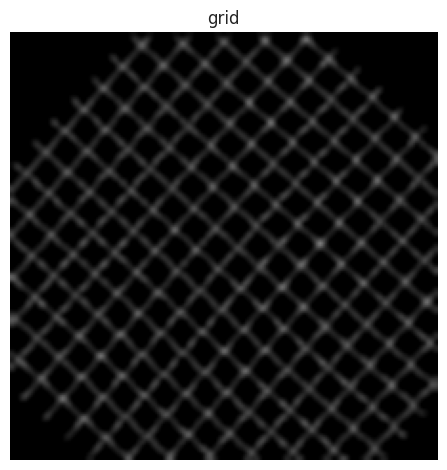

In [56]:
dtd_train.plot_image(-1)

### Config

Create a config for the experiments and print its settings.

Enable extra hyperparameters and regularization techniques in the config.

In [57]:
scheduler = SchedulerConfig(
    enabled=True,
    warmup_epochs=3,
    eta_min=1e-7,
    linear_start_factor=0.1,
    linear_end_factor=1.0,
)
scheduler.get_scheduler_settings()

{'enabled': True,
 'warmup_epochs': 3,
 'eta_min': 1e-07,
 'linear_start_factor': 0.1,
 'linear_end_factor': 1.0}

In [58]:
gradient_clipping = GradientClippingConfig(enabled=True, max_norm=2.0)
gradient_clipping.get_clipping_settings()

{'enabled': True, 'max_norm': 2.0}

In [59]:
early_stopping = EarlyStoppingConfig(
    enabled=True,
    patience=5,
    delta=0.005,
)
early_stopping.get_early_stopping_settings()

{'enabled': True, 'patience': 5, 'delta': 0.005}

In [60]:
from torch.optim import AdamW

config = Config(
    batch_size=64,
    num_epochs=15,
    lr=5e-5,
    optimizer=AdamW,
    weight_decay=1e-2,
    dropout_rate=0.5,
    early_stopping=early_stopping,
    gradient_clipping=gradient_clipping,
    scheduler=scheduler,
)
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 64,
 'lr': 5e-05,
 'num_epochs': 15,
 'optimizer': torch.optim.adamw.AdamW,
 'weight_decay': 0.01,
 'dropout_rate': 0.5,
 'early_stopping': {'enabled': True, 'patience': 5, 'delta': 0.005},
 'gradient_clipping': {'enabled': True, 'max_norm': 2.0},
 'scheduler': {'enabled': True,
  'warmup_epochs': 3,
  'eta_min': 1e-07,
  'linear_start_factor': 0.1,
  'linear_end_factor': 1.0}}

Plot the learning rate curve from scheduling settings.

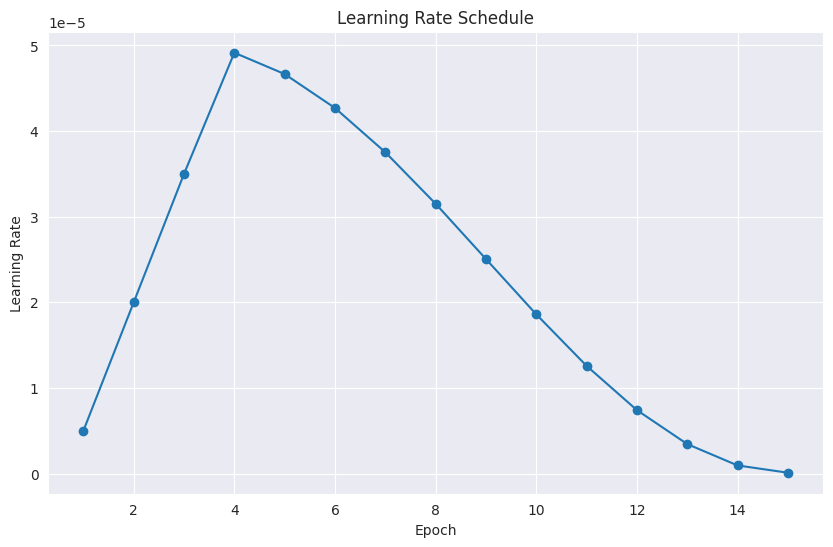

In [61]:
plot_learning_rate_scheduling(
    num_epochs=config.num_epochs,
    num_warmup_epochs=config.scheduler.warmup_epochs,
    linear_start_factor=config.scheduler.linear_start_factor,
    linear_end_factor=config.scheduler.linear_end_factor,
    base_lr=config.lr,
    eta_min=config.scheduler.eta_min,
)

Create empty arrays to store accuracies for each dataset.

In [62]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Fine-tuning with data augmentations


Train the entire model and all of its parameters on a new dataset.

#### RESISC45

In [63]:
swin_resisc45 = Backbone(
    model_names["Swin"],
    num_classes=len(resisc45_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate,
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([45, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
get_model_params(swin_resisc45)

Parameters: 86.79M


In [65]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc, _, _, _ = train_model(
    swin_resisc45,
    resisc45_train,
    config,
    "swin",
    val=resisc45_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 99/99 [00:28<00:00,  3.52it/s]


Epochs: 1/15 | train_loss: 2.6834 | train_acc: 0.3243 | val_loss: 0.8653 | val_acc: 0.8081


100%|██████████| 99/99 [00:28<00:00,  3.46it/s]


Epochs: 2/15 | train_loss: 0.5544 | train_acc: 0.8445 | val_loss: 0.2177 | val_acc: 0.9314


100%|██████████| 340/340 [02:34<00:00,  2.19it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 99/99 [00:27<00:00,  3.54it/s]


Epochs: 3/15 | train_loss: 0.2396 | train_acc: 0.9290 | val_loss: 0.1693 | val_acc: 0.9421


100%|██████████| 99/99 [00:28<00:00,  3.47it/s]


Epochs: 4/15 | train_loss: 0.1514 | train_acc: 0.9535 | val_loss: 0.1687 | val_acc: 0.9511


100%|██████████| 99/99 [00:26<00:00,  3.70it/s]


Epochs: 5/15 | train_loss: 0.0892 | train_acc: 0.9713 | val_loss: 0.1713 | val_acc: 0.9541


100%|██████████| 99/99 [00:26<00:00,  3.70it/s]


Epochs: 6/15 | train_loss: 0.0490 | train_acc: 0.9850 | val_loss: 0.2042 | val_acc: 0.9467


100%|██████████| 99/99 [00:26<00:00,  3.69it/s]


Epochs: 7/15 | train_loss: 0.0346 | train_acc: 0.9896 | val_loss: 0.1681 | val_acc: 0.9611


100%|██████████| 99/99 [00:29<00:00,  3.31it/s]

Epochs: 8/15 | train_loss: 0.0148 | train_acc: 0.9953 | val_loss: 0.2065 | val_acc: 0.9559
Early stopping triggered. Stopping training and saving the model...


In [66]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    swin_resisc45, resisc45_test, config
)

100%|██████████| 99/99 [00:30<00:00,  3.27it/s]

test_loss: 0.2380 | test_acc: 0.9489


In [67]:
resisc45_accs.append(resisc45_acc)

In [68]:
get_top_5_accuracies(resisc45_per_class_acc)

[('baseball diamond', 1.0),
 ('beach', 1.0),
 ('chaparral', 1.0),
 ('island', 1.0),
 ('airplane', 0.9940828402366864)]

In [69]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('church', 0.8251748251748252),
 ('dense residential', 0.8263888888888888),
 ('commercial area', 0.8428571428571429),
 ('wetland', 0.864406779661017),
 ('railway station', 0.8766233766233766)]

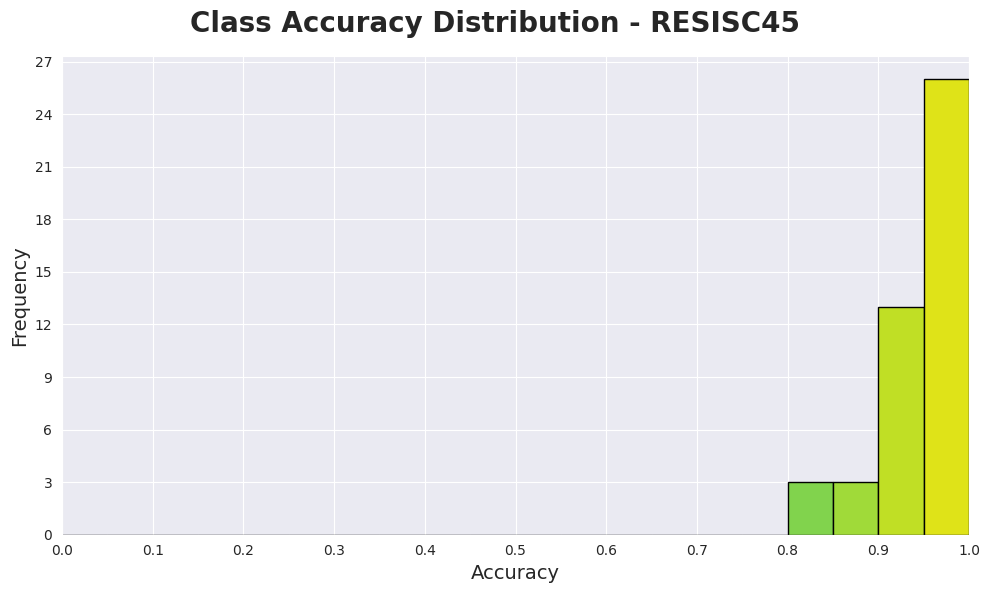

In [70]:
plot_per_class_accuracies(resisc45_per_class_acc, "RESISC45", num_bins=20)

#### Food-101

In [71]:
swin_food101 = Backbone(
    model_names["Swin"],
    num_classes=len(food101_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate,
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([101, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
get_model_params(swin_food101)

Parameters: 86.85M


In [73]:
food101_loss, food101_acc, food101_per_class_acc, _, _, _ = train_model(
    swin_food101,
    food101_train,
    config,
    "swin",
    val=food101_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

 77%|███████▋  | 699/908 [06:44<01:57,  1.78it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 395/395 [02:41<00:00,  2.45it/s]


Epochs: 1/15 | train_loss: 3.3300 | train_acc: 0.2741 | val_loss: 1.3273 | val_acc: 0.7149


100%|██████████| 395/395 [02:42<00:00,  2.42it/s]


Epochs: 2/15 | train_loss: 1.1402 | train_acc: 0.7164 | val_loss: 0.6090 | val_acc: 0.8367


100%|██████████| 908/908 [08:23<00:00,  1.80it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 395/395 [02:35<00:00,  2.54it/s]


Epochs: 3/15 | train_loss: 0.6838 | train_acc: 0.8203 | val_loss: 0.5727 | val_acc: 0.8511


100%|██████████| 395/395 [02:42<00:00,  2.42it/s]


Epochs: 4/15 | train_loss: 0.4727 | train_acc: 0.8706 | val_loss: 0.5932 | val_acc: 0.8467


100%|██████████| 395/395 [02:48<00:00,  2.34it/s]


Epochs: 5/15 | train_loss: 0.2947 | train_acc: 0.9179 | val_loss: 0.6177 | val_acc: 0.8503


100%|██████████| 395/395 [02:46<00:00,  2.37it/s]


Epochs: 6/15 | train_loss: 0.1817 | train_acc: 0.9480 | val_loss: 0.6348 | val_acc: 0.8540


100%|██████████| 395/395 [02:43<00:00,  2.42it/s]


Epochs: 7/15 | train_loss: 0.1139 | train_acc: 0.9668 | val_loss: 0.6694 | val_acc: 0.8572


100%|██████████| 395/395 [02:45<00:00,  2.39it/s]

Epochs: 8/15 | train_loss: 0.0714 | train_acc: 0.9794 | val_loss: 0.7156 | val_acc: 0.8603
Early stopping triggered. Stopping training and saving the model...


In [74]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    swin_food101, food101_test, config
)

100%|██████████| 395/395 [02:49<00:00,  2.33it/s]

test_loss: 0.4571 | test_acc: 0.9017


In [75]:
food101_accs.append(food101_acc)

In [76]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 1.0),
 ('hot and sour soup', 0.992),
 ('oysters', 0.984),
 ('pad thai', 0.984),
 ('spaghetti bolognese', 0.984)]

In [77]:
get_bottom_5_accuracies(food101_per_class_acc)

[('steak', 0.68),
 ('pork chop', 0.704),
 ('foie gras', 0.732),
 ('bread pudding', 0.74),
 ('huevos rancheros', 0.76)]

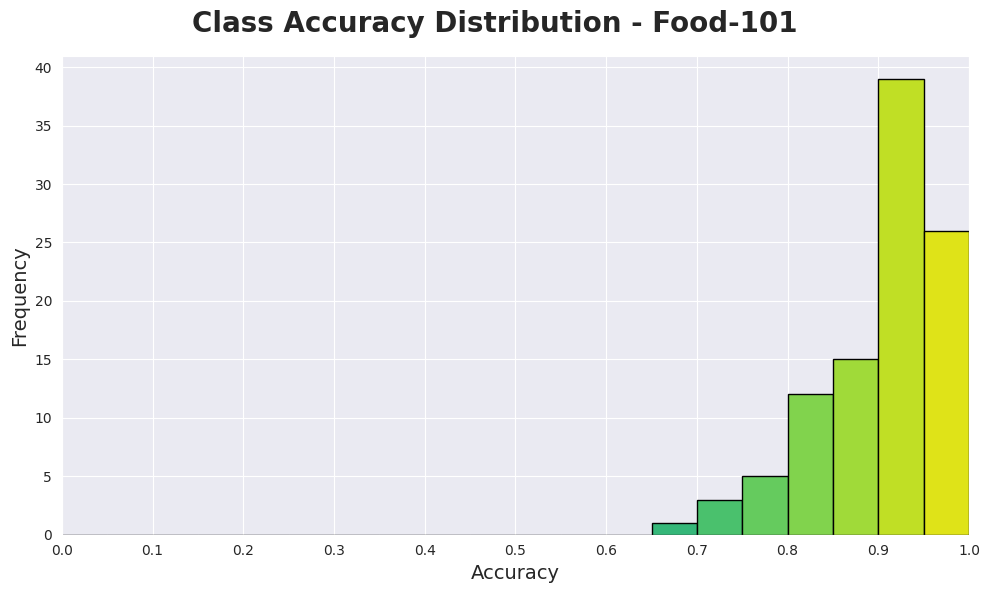

In [78]:
plot_per_class_accuracies(food101_per_class_acc, "Food-101", num_bins=20)

#### FER2013

In [79]:
swin_fer2013 = Backbone(
    model_names["Swin"],
    num_classes=len(fer2013_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate,
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([7, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
get_model_params(swin_fer2013)

Parameters: 86.75M


In [81]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc, _, _, _ = train_model(
    swin_fer2013,
    fer2013_train,
    config,
    "swin",
    val=fer2013_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 57/57 [00:12<00:00,  4.51it/s]


Epochs: 1/15 | train_loss: 1.3876 | train_acc: 0.4673 | val_loss: 1.0633 | val_acc: 0.5963


100%|██████████| 57/57 [00:12<00:00,  4.50it/s]


Epochs: 2/15 | train_loss: 1.0605 | train_acc: 0.6020 | val_loss: 0.9256 | val_acc: 0.6531


100%|██████████| 516/516 [03:29<00:00,  2.46it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 57/57 [00:12<00:00,  4.53it/s]


Epochs: 3/15 | train_loss: 0.9067 | train_acc: 0.6641 | val_loss: 0.8783 | val_acc: 0.6776


100%|██████████| 57/57 [00:12<00:00,  4.42it/s]


Epochs: 4/15 | train_loss: 0.7776 | train_acc: 0.7159 | val_loss: 0.8506 | val_acc: 0.6935


100%|██████████| 57/57 [00:13<00:00,  4.38it/s]


Epochs: 5/15 | train_loss: 0.5941 | train_acc: 0.7839 | val_loss: 0.9281 | val_acc: 0.6949


100%|██████████| 57/57 [00:13<00:00,  4.32it/s]


Epochs: 6/15 | train_loss: 0.4089 | train_acc: 0.8551 | val_loss: 0.9305 | val_acc: 0.7099


100%|██████████| 57/57 [00:12<00:00,  4.54it/s]


Epochs: 7/15 | train_loss: 0.2652 | train_acc: 0.9080 | val_loss: 1.1394 | val_acc: 0.7047


100%|██████████| 57/57 [00:12<00:00,  4.54it/s]


Epochs: 8/15 | train_loss: 0.1707 | train_acc: 0.9417 | val_loss: 1.3964 | val_acc: 0.6943


100%|██████████| 57/57 [00:12<00:00,  4.53it/s]

Epochs: 9/15 | train_loss: 0.1118 | train_acc: 0.9620 | val_loss: 1.5347 | val_acc: 0.7088
Early stopping triggered. Stopping training and saving the model...


In [82]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    swin_fer2013, fer2013_test, config
)

100%|██████████| 57/57 [00:13<00:00,  4.30it/s]

test_loss: 1.4245 | test_acc: 0.7158


In [83]:
fer2013_accs.append(fer2013_acc)

In [84]:
fer2013_per_class_acc

{'angry': 0.6008146639511202,
 'disgust': 0.7272727272727273,
 'fear': 0.5056818181818182,
 'happy': 0.8589306029579067,
 'sad': 0.6548821548821548,
 'surprise': 0.8701923076923077,
 'neutral': 0.7364217252396166}

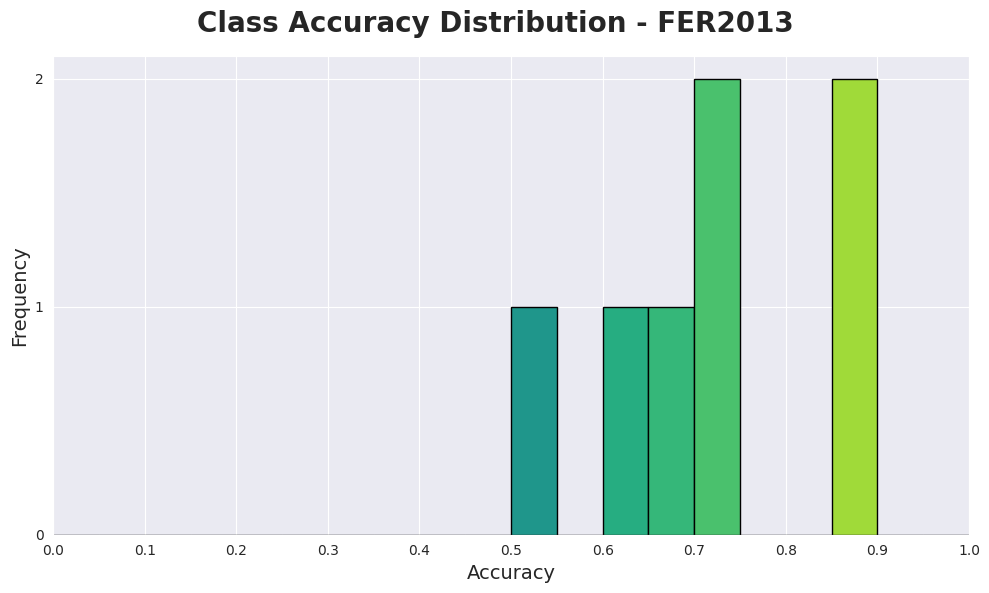

In [85]:
plot_per_class_accuracies(fer2013_per_class_acc, "FER2013", num_bins=20)

#### PCam

In [86]:
swin_pcam = Backbone(
    model_names["Swin"],
    num_classes=len(pcam_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate,
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
get_model_params(swin_pcam)

Parameters: 86.75M


In [88]:
pcam_loss, pcam_acc, pcam_per_class_acc, _, _, _ = train_model(
    swin_pcam,
    pcam_train,
    config,
    "swin",
    val=pcam_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 512/512 [02:09<00:00,  3.96it/s]


Epochs: 1/15 | train_loss: 0.1732 | train_acc: 0.9327 | val_loss: 0.2602 | val_acc: 0.9120


100%|██████████| 512/512 [02:05<00:00,  4.09it/s]


Epochs: 2/15 | train_loss: 0.1157 | train_acc: 0.9586 | val_loss: 0.3135 | val_acc: 0.9075


100%|██████████| 4711/4711 [32:12<00:00,  2.44it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 512/512 [02:00<00:00,  4.24it/s]


Epochs: 3/15 | train_loss: 0.0889 | train_acc: 0.9692 | val_loss: 0.4084 | val_acc: 0.8991


100%|██████████| 512/512 [02:05<00:00,  4.09it/s]


Epochs: 4/15 | train_loss: 0.0727 | train_acc: 0.9751 | val_loss: 0.2521 | val_acc: 0.9213


100%|██████████| 512/512 [02:02<00:00,  4.17it/s]


Epochs: 5/15 | train_loss: 0.0501 | train_acc: 0.9832 | val_loss: 0.3810 | val_acc: 0.9088


100%|██████████| 512/512 [01:59<00:00,  4.27it/s]


Epochs: 6/15 | train_loss: 0.0335 | train_acc: 0.9890 | val_loss: 0.5223 | val_acc: 0.8968


100%|██████████| 512/512 [02:05<00:00,  4.08it/s]


Epochs: 7/15 | train_loss: 0.0232 | train_acc: 0.9924 | val_loss: 0.5683 | val_acc: 0.8880


100%|██████████| 512/512 [02:04<00:00,  4.11it/s]


Epochs: 8/15 | train_loss: 0.0161 | train_acc: 0.9949 | val_loss: 0.5463 | val_acc: 0.9139


100%|██████████| 512/512 [02:04<00:00,  4.13it/s]

Epochs: 9/15 | train_loss: 0.0099 | train_acc: 0.9970 | val_loss: 0.5181 | val_acc: 0.9202
Early stopping triggered. Stopping training and saving the model...


In [89]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(swin_pcam, pcam_test, config)

100%|██████████| 512/512 [02:04<00:00,  4.11it/s]

test_loss: 0.6695 | test_acc: 0.8988


In [90]:
pcam_accs.append(pcam_acc)

In [91]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.9646147275944116,
 'lymph node tumor tissue': 0.8329974964889785}

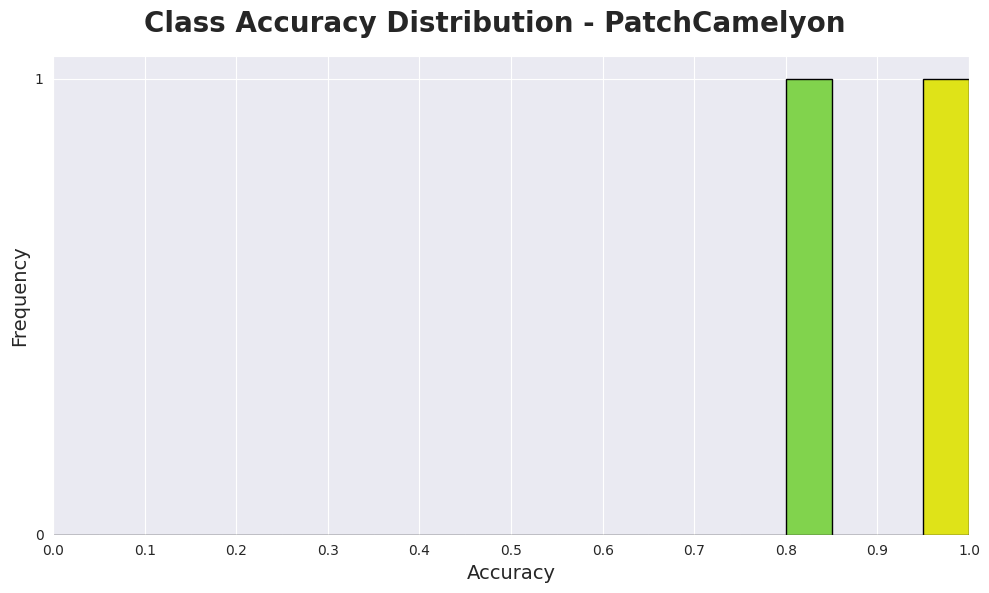

In [92]:
plot_per_class_accuracies(pcam_per_class_acc, "PatchCamelyon", num_bins=20)

#### SUN397

In [93]:
swin_sun397 = Backbone(
    model_names["Swin"],
    num_classes=len(sun397_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate,
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([397, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [94]:
get_model_params(swin_sun397)

Parameters: 87.15M


In [95]:
sun397_loss, sun397_acc, sun397_per_class_acc, _, _, _ = train_model(
    swin_sun397,
    sun397_train,
    config,
    "swin",
    val=sun397_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 170/170 [01:12<00:00,  2.34it/s]


Epochs: 1/15 | train_loss: 4.4820 | train_acc: 0.2226 | val_loss: 2.3100 | val_acc: 0.5354


100%|██████████| 170/170 [01:14<00:00,  2.29it/s]


Epochs: 2/15 | train_loss: 1.6501 | train_acc: 0.6177 | val_loss: 0.8771 | val_acc: 0.7562


100%|██████████| 1368/1368 [13:05<00:00,  1.74it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 170/170 [01:13<00:00,  2.31it/s]


Epochs: 3/15 | train_loss: 0.9864 | train_acc: 0.7349 | val_loss: 0.7646 | val_acc: 0.7779


100%|██████████| 170/170 [01:13<00:00,  2.31it/s]


Epochs: 4/15 | train_loss: 0.7210 | train_acc: 0.7954 | val_loss: 0.7885 | val_acc: 0.7798


100%|██████████| 170/170 [01:12<00:00,  2.34it/s]


Epochs: 5/15 | train_loss: 0.4871 | train_acc: 0.8551 | val_loss: 0.7744 | val_acc: 0.7890


100%|██████████| 170/170 [01:14<00:00,  2.30it/s]


Epochs: 6/15 | train_loss: 0.3245 | train_acc: 0.9004 | val_loss: 0.8292 | val_acc: 0.7838


100%|██████████| 170/170 [01:13<00:00,  2.30it/s]


Epochs: 7/15 | train_loss: 0.2080 | train_acc: 0.9354 | val_loss: 0.9096 | val_acc: 0.7851


100%|██████████| 170/170 [01:12<00:00,  2.34it/s]

Epochs: 8/15 | train_loss: 0.1323 | train_acc: 0.9594 | val_loss: 0.9966 | val_acc: 0.7877
Early stopping triggered. Stopping training and saving the model...


In [96]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    swin_sun397, sun397_test, config
)

100%|██████████| 340/340 [02:25<00:00,  2.34it/s]


test_loss: 0.9771 | test_acc: 0.7894


In [97]:
sun397_accs.append(sun397_acc)

In [98]:
get_top_5_accuracies(sun397_per_class_acc)

[('auto factory', 1.0),
 ('ball pit', 1.0),
 ('batters box', 1.0),
 ('bullring', 1.0),
 ('discotheque', 1.0)]

In [99]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('library (outdoor)', 0.047619047619047616),
 ('bistro (indoor)', 0.10526315789473684),
 ('dinette (home)', 0.13333333333333333),
 ('inn (outdoor)', 0.13793103448275862),
 ('recreation room', 0.14814814814814814)]

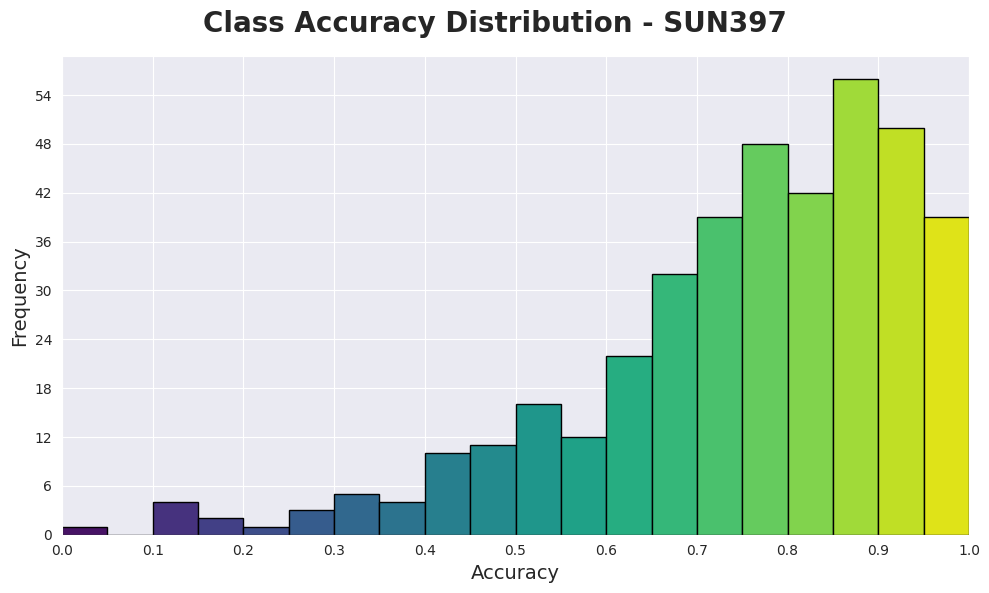

In [100]:
plot_per_class_accuracies(sun397_per_class_acc, "SUN397", num_bins=20)

#### DTD

In [101]:
swin_dtd = Backbone(
    model_names["Swin"],
    num_classes=len(dtd_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate,
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([47, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
get_model_params(swin_dtd)

Parameters: 86.79M


In [103]:
dtd_loss, dtd_acc, dtd_per_class_acc, _, _, _ = train_model(
    swin_dtd,
    dtd_train,
    config,
    "swin",
    val=dtd_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


Epochs: 1/15 | train_loss: 3.8768 | train_acc: 0.0321 | val_loss: 3.7432 | val_acc: 0.0665


100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


Epochs: 2/15 | train_loss: 3.2936 | train_acc: 0.1989 | val_loss: 2.3305 | val_acc: 0.5638


100%|██████████| 61/61 [00:35<00:00,  1.73it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 6/6 [00:02<00:00,  2.42it/s]


Epochs: 3/15 | train_loss: 1.5241 | train_acc: 0.6191 | val_loss: 0.8239 | val_acc: 0.7819


100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


Epochs: 4/15 | train_loss: 0.7530 | train_acc: 0.7900 | val_loss: 0.7599 | val_acc: 0.7926


100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Epochs: 5/15 | train_loss: 0.4114 | train_acc: 0.8841 | val_loss: 0.5737 | val_acc: 0.8245


100%|██████████| 6/6 [00:02<00:00,  2.45it/s]


Epochs: 6/15 | train_loss: 0.2064 | train_acc: 0.9424 | val_loss: 0.7029 | val_acc: 0.8032


100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


Epochs: 7/15 | train_loss: 0.1200 | train_acc: 0.9674 | val_loss: 0.7353 | val_acc: 0.8298


100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


Epochs: 8/15 | train_loss: 0.0705 | train_acc: 0.9810 | val_loss: 0.6840 | val_acc: 0.8457


100%|██████████| 6/6 [00:02<00:00,  2.33it/s]


Epochs: 9/15 | train_loss: 0.0444 | train_acc: 0.9905 | val_loss: 0.6967 | val_acc: 0.8431


100%|██████████| 6/6 [00:02<00:00,  2.38it/s]

Epochs: 10/15 | train_loss: 0.0244 | train_acc: 0.9951 | val_loss: 0.7386 | val_acc: 0.8378
Early stopping triggered. Stopping training and saving the model...


In [104]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(swin_dtd, dtd_test, config)

100%|██████████| 30/30 [00:12<00:00,  2.47it/s]

test_loss: 0.8777 | test_acc: 0.8074


In [105]:
dtd_accs.append(dtd_acc)

In [106]:
get_top_5_accuracies(dtd_per_class_acc)

[('chequered', 0.975),
 ('crystalline', 0.975),
 ('lacelike', 0.975),
 ('scaly', 0.975),
 ('frilly', 0.95)]

In [107]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('blotchy', 0.45),
 ('stained', 0.55),
 ('grid', 0.575),
 ('woven', 0.575),
 ('bumpy', 0.6)]

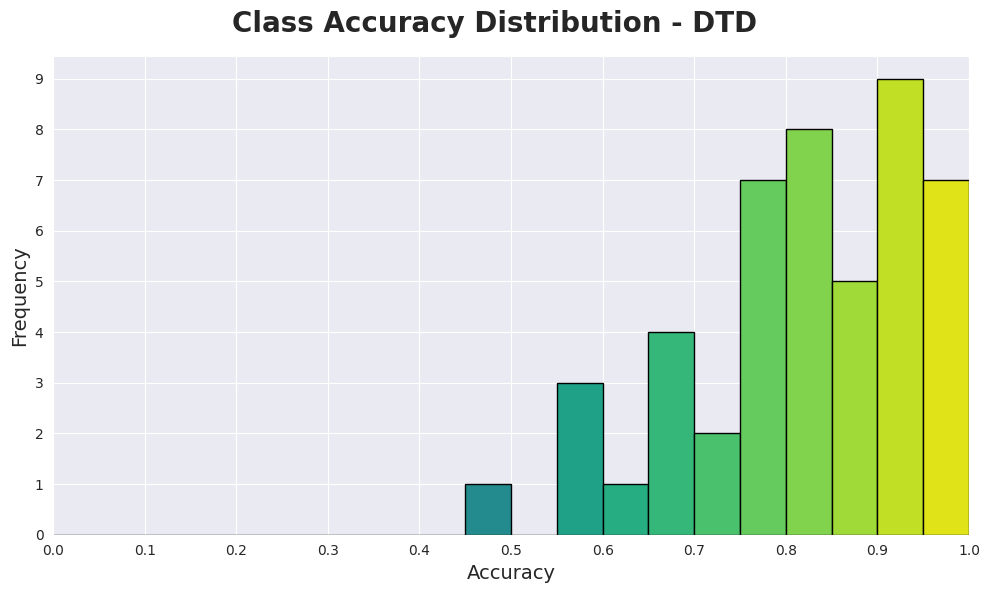

In [108]:
plot_per_class_accuracies(dtd_per_class_acc, "DTD", num_bins=20)

### Results

Display the results of the analysis in dataframe.

In [ ]:
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [ ]:
labels = ["RESISC45", "Food-101", "FER2013", "PatchCamelyon", "SUN397", "DTD"]

In [ ]:
acc_dict = create_accuracy_dict(results, labels)

In [ ]:
df = pd.DataFrame(
    results, columns=["fine-tuning with data augmentations"], index=labels
)
df

,fine-tuning with data augmentations
RESISC45,0.948889
Food-101,0.901703
FER2013,0.715798
PatchCamelyon,0.898834
SUN397,0.789425
DTD,0.807447
